# **Zero-Loss Peak Subtraction with Neural Networks**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/CBL-ML/blob/tutorial/Tutorial/EELS_tutorial.ipynb)

## Loading the data

First of all, let us install and import all the required modules

In [1]:
!pip install ncempy

In [2]:
from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageClass as EELSImage
import trainZLP as ZLPnn
#from trainZLP import train_nn_scaled

In this tutorial, we will study.....

The spectral image can be imported with the lines below

In [3]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting the data

Integrated intensity 2D plot + show selection

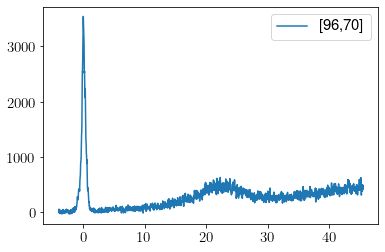

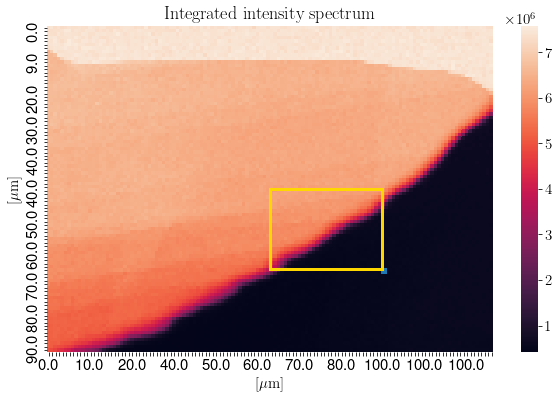

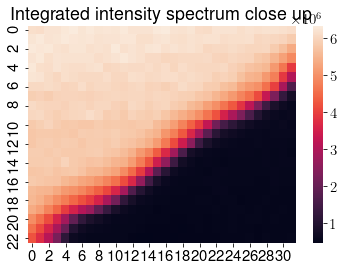

In [4]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.75 * full_width), int(0.75 * full_height)
im.plot_spectrum(loc_y, loc_x)

xmin, width = 0.5, 0.25
ymin, height = 0.5, 0.25
window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Monte Carlo replica method

Train on the replicas within a preselected cluster. One feature only: intensity. Not the integrated intensity.

## Constructing the Neural Network

In [5]:
class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.mean(torch.square((output - target)/error))
    return loss

NameError: name 'nn' is not defined

In [ ]:
test = np.reshape(im.data_zoomed[0,1,:], (1, -1))
ZLPnn.smooth(test)

## Smoothing

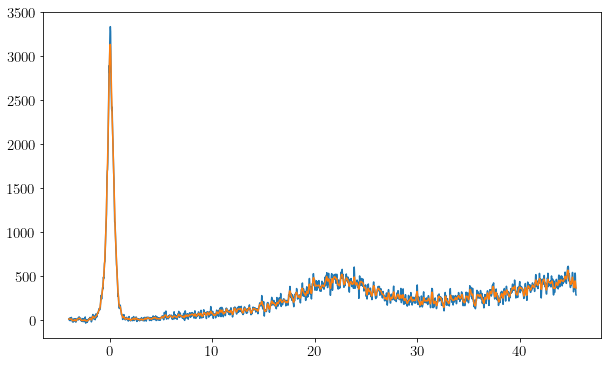

In [7]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -1, :])
plt.plot(im.deltaE, data_smooth[-1,:])
plt.show()

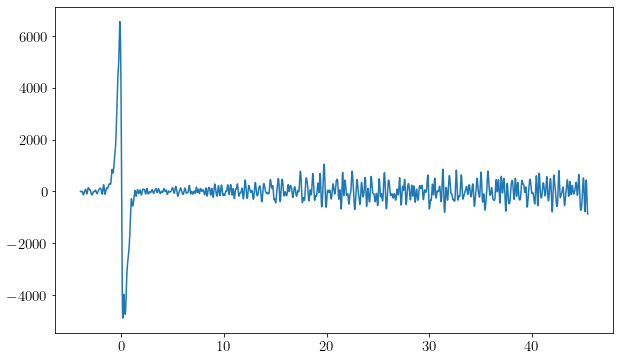

In [8]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

## Finding $dE_1$ and $dE_2$

@Isabel: explain upper bound on dE2

In [12]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)

times_dE1 = 3
min_dE2 = im.deltaE.max() - im.ddeltaE*im.l*0.05 #at least 5% zeros at end
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [28]:
data_zoomed_concat[-2,:]

array([-24.292501 , -19.50395  ,  -4.1715503, ..., 402.20734  ,
       393.45233  , 384.0428   ], dtype=float32)

In [16]:
dE1, dE2

(1.7850000265985726, 5.355000079795718)

In [19]:
select1 = len(im.deltaE[im.deltaE<dE1])
select2 = len(im.deltaE[im.deltaE>dE2])
select1, select2
np.log(data_zoomed_concat[:, :select1])

/Users/jaco/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


array([[4.178281 , 3.5008006, 3.6139133, ..., 6.444159 , 6.310666 ,
        6.4205832],
       [3.7978787, 3.902416 , 3.5750678, ..., 6.24389  , 6.3010964,
        6.2799125],
       [4.5470753, 3.3617027, 4.461713 , ..., 6.416911 , 6.285915 ,
        6.174542 ],
       ...,
       [      nan, 1.8169425,       nan, ..., 2.571357 , 2.0502326,
              nan],
       [      nan,       nan,       nan, ..., 2.7068212,       nan,
        1.9336172],
       [2.5924935, 1.951995 , 3.2000902, ..., 2.9941244, 2.8381462,
        2.542067 ]], dtype=float32)

## Training data

In [ ]:
def smooth_clusters(image, clusters, window_len = None):
    smoothed_clusters = np.zeros((len(clusters)), dtype = object)
    for i in range(len(clusters)):
        smoothed_clusters[i] = smooth(clusters[i])
    return smoothed_clusters

def derivative_clusters(image, clusters):
    dx = image.ddeltaE
    der_clusters = np.zeros((len(clusters)), dtype = object)
    for i in range(len(clusters)):
        der_clusters[i] = (clusters[i][:,1:]-clusters[i][:,:-1])/dx
    return der_clusters

def determine_dE1(image, dy_dx_clusters, y_smooth_clusters):
    dy_dx_avg = np.zeros((len(y_smooth_clusters), image.l - 1))
    dE1_clusters = np.zeros(len(y_smooth_clusters))
    for i in range(len(y_smooth_clusters)):
        dy_dx_avg[i, :] = np.average(dy_dx_clusters[i], axis=0)
        y_smooth_cluster_avg = np.average(y_smooth_clusters[i], axis=0)
        dE1_clusters[i] = find_dE1(image, dy_dx_avg[i, :], y_smooth_cluster_avg)

Rescaling to range 0.1-0.9

In [ ]:
n_rep = im.data.shape[0] * im.data.shape[1]
n_epochs = 100
path_to_models = 'models/'
display_step = 100
added_dE1 = 0.7

im.train_ZLPs(data_zoomed, n_rep = n_rep,
              n_epochs = n_epochs, 
              path_to_models = path_to_models, 
              display_step = display_step,  
              added_dE1 = added_dE1)

## Training the ZLP

Pretrained models

## ZLP subtraction

## Bandgap fit